<a href="https://colab.research.google.com/github/ariaanthor/Web-Scraping-Using-Covid-19-Data/blob/main/Web_Scraping_Using_Covid_19_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Prepare Data

# source of data: https://www.kaggle.com/roche-data-science-coalition/uncover?

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime, timedelta
import sklearn
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import math
from math import sqrt
import random
import scipy
from scipy.interpolate import make_interp_spline

# see all columns and rows
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 40)
# set seed
random.seed(1)

import gdown 
gdown.download('https://drive.google.com/uc?id=1oK8AlCRFp4isBJQv-AZnC_zr-ZvrOOxd','covid-statistics-by-us-states-daily-updates.csv',True);

raw_data = pd.read_csv('covid-statistics-by-us-states-daily-updates.csv')

# turn date into datetime object
raw_data["date"] = pd.to_datetime(raw_data["date"], format="%Y-%m-%d")

raw_data.set_index("date", inplace = True, drop = False)

state_df_list = []
for name, df in raw_data.groupby("state"):
  tomorrow_data = df[['date','positiveincrease']]
  tomorrow_data.columns = ['tomorrow_date', 'tomorrow_new_pos']
  tomorrow_data['today_date'] = tomorrow_data.tomorrow_date - timedelta(days=1)
  tomorrow_data.set_index("today_date", inplace = True)
  state_df = df.join(tomorrow_data, how = 'inner')
  state_df_list.append(state_df)

data = pd.concat(state_df_list)
data.drop(['date','tomorrow_date'],axis=1,inplace=True)
data = data[~data.totaltestresultsincrease.isna()]
data = data[~data.total.isna()]
data = data[~data.positive.isna()]
data.negative = data.total - data.positive

data.sort_index(inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
data.head(1)

,state,positive,negative,pending,hospitalizedcurrently,hospitalizedcumulative,inicucurrently,inicucumulative,onventilatorcurrently,onventilatorcumulative,recovered,hash,datechecked,death,hospitalized,total,totaltestresults,posneg,fips,deathincrease,hospitalizedincrease,negativeincrease,positiveincrease,totaltestresultsincrease,tomorrow_new_pos
2020-01-23,WA,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,faa0d0b985f479eac50082e417dc84f9e645db8f,2020-01-23 21:00:00,NaN,NaN,1.0,1.0,1.0,53,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
data = data[["state", "positive", "negative", "total", "hospitalizedincrease", "negativeincrease", "positiveincrease", "totaltestresultsincrease", "tomorrow_new_pos"]]
data.head(15)

,state,positive,negative,total,hospitalizedincrease,negativeincrease,positiveincrease,totaltestresultsincrease,tomorrow_new_pos
2020-01-23,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-27,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-28,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-29,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-30,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-01-31,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-02-01,WA,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
num_rows = 50
num_columns = 50000
print (num_rows, "rows")
print (num_columns, "columns")

50 rows
50000 columns


You've chosen to see the data for the state of TX


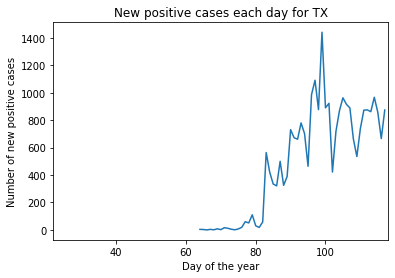

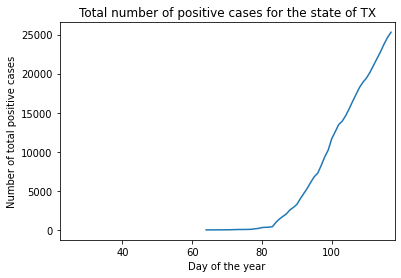

In [ ]:
#@title ### Comparing States

# get state
state = "tx" #@param {type:"string"}

# get uppercase version
state=state.upper()

# get states
states = set(data["state"])

# check to see if entry is in the state
if state not in states:
    raise ValueError("Abbreviation isn't a state. Please try again")
print(f"You've chosen to see the data for the state of {state}")


# check out graphs of positive cases, by week
new_data=data[data["state"] == state]
new_data.index = (new_data.index - datetime(2020, 1, 1)).days

plt.plot(new_data.index, new_data.tomorrow_new_pos)
plt.title(f"New positive cases each day for {state}")
plt.ylabel("Number of new positive cases")
plt.xlabel("Day of the year")
plt.xlim(22, 118)
plt.show()

plt.plot(new_data.index, new_data.positive)
plt.title(f"Total number of positive cases for the state of {state}")
plt.ylabel("Number of total positive cases")
plt.xlabel("Day of the year")
plt.xlim(22, 118)
plt.show()

In [ ]:
X_raw = data.drop(["tomorrow_new_pos"], axis = "columns")
y_raw = data[["tomorrow_new_pos"]]
print(X_raw.shape)
print(y_raw.shape)

(2915, 8)
(2915, 1)


In [ ]:
one_hot_columns = pd.get_dummies(X_raw.state, prefix="state")
X = pd.concat([X_raw, one_hot_columns], axis=1)
X.drop('state',axis=1,inplace=True)

X["day_of_year"] = (X.index - datetime(2020, 1, 1)).days

X.reset_index(inplace = True, drop=True)
y = y_raw.reset_index(drop = True)

X.head(5)

,positive,negative,total,hospitalizedincrease,negativeincrease,positiveincrease,totaltestresultsincrease,state_AK,state_AL,state_AR,state_AS,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,state_GU,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MP,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_PR,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VI,state_VT,state_WA,state_WI,state_WV,state_WY,day_of_year
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,23
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,24
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,25
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,26


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2332, 64) (583, 64) (2332, 1) (583, 1)


In [ ]:
linear = linear_model.LinearRegression()
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)

You've chosen to see the data for the state of TX


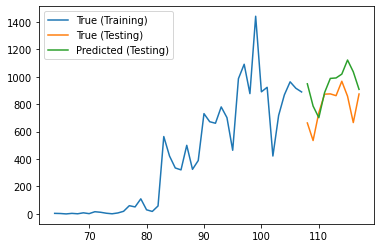

In [ ]:
#@title ### Predictions
state = "tx" #@param {type:"string"}

def plot_true_and_pred(state, y_pred):
  # get uppercase version
  state=state.upper()

  # check to see if entry is in the state
  if state not in set(data["state"]):
      raise ValueError("Abbreviation isn't a state. Please try again")
  print(f"You've chosen to see the data for the state of {state}")

  y_pred_series = pd.Series(y_pred.squeeze(), index = y_test.index)

  X_train_state = X_train[X_train["state_"+state] == 1]
  X_test_state = X_test[X_test["state_"+state] == 1]

  early_true = y_train.loc[X_train_state.index]
  late_true = y_test.loc[X_test_state.index]
  late_pred = y_pred_series.loc[X_test_state.index]

  plt.plot(X_train_state.day_of_year, early_true)
  plt.plot(X_test_state.day_of_year, late_true)
  plt.plot(X_test_state.day_of_year, late_pred)
  plt.legend(["True (Training)", "True (Testing)", "Predicted (Testing)"])
  plt.show()

plot_true_and_pred(state, y_pred)
